In [1]:
import open3d as o3d
import numpy as np
import copy
import cv2
import matplotlib.pyplot as plt
import os

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [182]:
# Load the meshes
mesh_name = "001101" # must be 4 digits: xx01 indicates lower jaw, xx02 indicates upper jaw
origin_file_path = f"D:\sunny\Codes\DPS\data_teethseg\origin\{mesh_name}_origin.ply"
label_file_path = f"D:\sunny\Codes\DPS\data_teethseg\label\{mesh_name}.ply"
raw_origin_mesh = o3d.io.read_triangle_mesh(origin_file_path)
raw_label_mesh = o3d.io.read_triangle_mesh(label_file_path)

axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=50, origin=[0,0,0])

### 0.Recenter mesh

In [183]:
# Find two end points of the intraoral mesh by the max and min theta values
def find_key_points(mesh):
    vertices = np.asarray(mesh.vertices)
    x,y,z = vertices[:,0], vertices[:,1], vertices[:,2]
    theta = np.arctan2(z,x) + np.pi/2
    theta = np.where(theta<0, theta+2*np.pi, theta) # if theta < 0, add 2pi to make it positive
    endpt1 = vertices[np.argmin(theta)]
    endpt2 = vertices[np.argmax(theta)]
    # shift both endpts to x-z plane (i.e.y=0)
    endpt1[1] = 0
    endpt2[1] = 0
    centre = (endpt1 + endpt2) / 2
    return endpt1, endpt2, centre

# Recentre the mesh with centre keypoint at the origin, rotate the mesh about y axis such that x-axis point to endpt1
def recentre_mesh(mesh):
    endpt1, endpt2, centre_keypt = find_key_points(mesh)
    vertices = np.asarray(mesh.vertices)
    vertices = vertices - centre_keypt
    endpt1 = endpt1 - centre_keypt
    endpt2 = endpt2 - centre_keypt


    # Rotate the mesh about y axis such that x-axis point to endpt1
    theta = np.arctan2(endpt1[2], endpt1[0])
    # print(f"endpt1: {endpt1}, endpt2: {endpt2}, theta: {theta}")
    R = np.array([[np.cos(theta), 0, np.sin(theta)], [0, 1, 0], [-np.sin(theta), 0, np.cos(theta)]])
    vertices = np.dot(vertices, R.T)
    endpt1 = np.dot(endpt1, R.T)
    endpt2 = np.dot(endpt2, R.T)
    print(f"endpt1: {endpt1}, endpt2: {endpt2}")
    assert endpt1[2] < 1e-6, f"end point 1 {endpt1} is not on x-axis"
    assert endpt2[2] < 1e-6, f"end point 2 {endpt2} is not on x-axis"  

    mesh.vertices = o3d.utility.Vector3dVector(vertices)
    return mesh, endpt1, endpt2

In [184]:
# first translate mesh with its center at origin
raw_origin_mesh.translate(-raw_origin_mesh.get_center())
origin_mesh, edp1, edp2 = recentre_mesh(raw_origin_mesh)
label_mesh, _, _ = recentre_mesh(raw_label_mesh)

# Visualize the recentred mesh with key points, with axis drawn
pc = o3d.geometry.PointCloud()
pc.points = o3d.utility.Vector3dVector([edp1, edp2])
pc.paint_uniform_color([1, 0, 0])

o3d.visualization.draw_geometries([origin_mesh, axes, pc])

endpt1: [2.52706048e+01 0.00000000e+00 1.11022302e-16], endpt2: [-2.52706048e+01  0.00000000e+00 -1.11022302e-16]
endpt1: [2.52706048e+01 0.00000000e+00 1.11022302e-16], endpt2: [-2.52706048e+01  0.00000000e+00 -1.11022302e-16]


### 1.Visualize curvatures

In [185]:
# def compute_vertex_curvatures(mesh):
#     vertices = np.asarray(mesh.vertices)
#     triangles = np.asarray(mesh.triangles)

#     # Initialize curvature array
#     curvature = np.zeros(vertices.shape[0])

#     # Compute the curvature for each vertex
#     for i in range(vertices.shape[0]):
#         # Get the one-ring neighborhood
#         adjacent_faces = np.any(triangles == i, axis=1)
#         adjacent_vertices = np.unique(triangles[adjacent_faces])
#         adjacent_vertices = adjacent_vertices[adjacent_vertices != i]

#         # Compute curvature (simple estimation, can be improved)
#         if len(adjacent_vertices) > 0:
#             diffs = vertices[adjacent_vertices] - vertices[i]
#             distances = np.linalg.norm(diffs, axis=1)
#             curvature[i] = np.sum(1.0 / distances)

#     return curvature

# # Compute curvatures
# curvatures = compute_vertex_curvatures(origin_mesh)

In [186]:
# from matplotlib import cm

# # Normalize curvatures to range [0, 1]
# curvatures_normalized = (curvatures - np.min(curvatures)) / (np.max(curvatures) - np.min(curvatures))

# # Map to colormap
# colormap = cm.get_cmap('jet')
# curvature_colors =  colormap(curvatures_normalized)[:, :3]  # Take RGB part

# visual_mesh = copy.deepcopy(origin_mesh)
# # Assign colors to vertices
# visual_mesh.vertex_colors = o3d.utility.Vector3dVector(curvature_colors)

# # Visualize the mesh
# o3d.visualization.draw_geometries([visual_mesh])

In [187]:
# print(np.mean(curvatures_normalized), np.std(curvatures_normalized))
# print(np.min(curvatures_normalized), np.max(curvatures_normalized))
# # mask for vertices with high curvature 
# curvature_mask = curvatures_normalized > 0.4
# visual_mesh = copy.deepcopy(origin_mesh)
# # Assign colors to vertices: red for high curvature, green for low curvature
# visual_mesh.vertex_colors = o3d.utility.Vector3dVector(np.where(curvature_mask[:, None], [1, 0, 0], [0, 1, 0]))

# # Visualize the mesh
# o3d.visualization.draw_geometries([visual_mesh])


### 2.Mesh Separation

Upper Surface

In [216]:
# Identify upward facing vertices (upper vertices) and visualize by coloring them with red
triangles = np.asarray(origin_mesh.triangles)
vertices = np.asarray(origin_mesh.vertices)
centre = np.mean(vertices, axis=0)
normals = np.asarray(origin_mesh.vertex_normals)
print(min(normals[:,1]), max(normals[:,1]))


vert_up_xpos_mask = np.logical_or((vertices[:,0]) > 10, (vertices[:,0]) < -10)
vert_up_ypos_mask = (vertices[:,1]) > -2
vert_up_norm_mask = normals[:,1] > 0.6
vert_up_mask = vert_up_xpos_mask & vert_up_ypos_mask & vert_up_norm_mask 
print(np.sum(vert_up_mask))
upward_mesh = copy.deepcopy(origin_mesh)

# Preserve connected vertices which belong to a big enough cluster (remove small disconnecting clusters)

# Extract upward facing triangles
upward_mask_triangles = np.all(vert_up_mask[triangles], axis=1) # all 3 vertices of the triangle are upward facing
upward_triangles = triangles[upward_mask_triangles]
upward_mesh.triangles = o3d.utility.Vector3iVector(upward_triangles)

# Remove disconnected small componenet pieces => preserve connected components with face size > 100
def remove_small_components(mesh, min_size=600):
    """ Remove small disconnected components from the mesh"""
    triangles = np.asarray(mesh.triangles)
    print(f"Number of triangles before: {len(triangles)}")
    components = np.array(mesh.cluster_connected_triangles()[0])
    comp_sizes = np.bincount(components)
    small_comp_indices = np.where(comp_sizes < min_size)[0]
    small_comp_mask = np.isin(components, small_comp_indices)

    removed_triangles = triangles[small_comp_mask]
    triangles = triangles[np.logical_not(small_comp_mask)]
    mesh.triangles = o3d.utility.Vector3iVector(triangles)
    print(f"Number of triangles after: {len(triangles)}")
    return mesh, triangles, removed_triangles
upward_mesh,_,_ = remove_small_components(upward_mesh, min_size=600)

# fill up enclosed holes in the mesh
upward_triangles = np.asarray(upward_mesh.triangles)

def set_difference(A, B):
    """ Return the elements in A but not in B"""
    A_view = A.view([('', A.dtype)] * A.shape[1])
    B_view = B.view([('', B.dtype)] * B.shape[1])
    C_view = np.setdiff1d(A_view, B_view)
    C = C_view.view(A.dtype).reshape(-1, A.shape[1])
    return C

unsampled_triangles = set_difference(triangles, upward_triangles)
# Extrac all components from unsampled_triangles except the biggest one
unsampled_mesh = copy.deepcopy(origin_mesh)
unsampled_mesh.triangles = o3d.utility.Vector3iVector(unsampled_triangles)

def keep_max_component(mesh):
    """ Preserve the biggest component from the mesh"""
    triangles = np.asarray(mesh.triangles)
    components = np.array(mesh.cluster_connected_triangles()[0])
    comp_sizes = np.bincount(components)
    max_comp_index = np.argmax(comp_sizes)
    max_comp_mask = components == max_comp_index
    small_comp_triangles = triangles[np.logical_not(max_comp_mask)]

    mesh.triangles = o3d.utility.Vector3iVector(triangles[max_comp_mask]) # keep the biggest component
    return mesh, small_comp_triangles
unsampled_mesh, to_upward_triangles = keep_max_component(unsampled_mesh)
# Add the unsampled mesh to the upward mesh
upward_mesh.triangles = o3d.utility.Vector3iVector(np.concatenate([upward_triangles, to_upward_triangles]))
upward_triangles = np.asarray(upward_mesh.triangles)
unsampled_triangles = np.asarray(unsampled_mesh.triangles)

# Draw 2 yz planes at x=14 and x=-14
plane1 = o3d.geometry.TriangleMesh.create_box(width=0.1, height=50, depth=50)
plane1.translate([12, 0, 0])
plane1.paint_uniform_color([0.8, 0.8, 0.8])

plane2 = o3d.geometry.TriangleMesh.create_box(width=0.1, height=50, depth=50)
plane2.translate([-12, 0, 0])
plane2.paint_uniform_color([0.8, 0.8, 0.8])

# colors = np.asarray(upward_mesh.vertex_colors)
# colors[upward_mask] = [1, 0, 0]
# upward_mesh.vertex_colors = o3d.utility.Vector3dVector(colors)
visual_mesh = copy.deepcopy(unsampled_mesh)
visual_mesh.paint_uniform_color([0.2, 0.2, 0.2])
o3d.visualization.draw_geometries([upward_mesh, visual_mesh, plane1, plane2, axes])

print(f"Number of triangles in upward mesh: {len(upward_triangles)}")
print(f"Number of triangles in unsampled mesh: {len(unsampled_triangles)}")
print(f"Number of triangles in origin mesh: {len(triangles)}")
assert len(upward_triangles) + len(unsampled_triangles) == len(triangles), "Sum of upward and unsampled triangles not equal to total triangles"

-0.9425114735279427 0.9999833209394614
8626
Number of triangles before: 15014
Number of triangles after: 13967
Number of triangles in upward mesh: 16408
Number of triangles in unsampled mesh: 31442
Number of triangles in origin mesh: 47850


Inner and Outer Surface


In [217]:
# Separate the original mesh vertices into inward-facing and outward-facing vertices relative to the origin
# With original (non re-centered mesh)

def separate_mesh_vertices_io(mesh):
    vertices = np.asarray(mesh.vertices)
    triangles = np.asarray(mesh.triangles)
    viewpt1 = np.mean(vertices, axis=0)
    vertices_1 = vertices - viewpt1
    viewpt2 = viewpt1 / 2
    vertices_2 = vertices - viewpt2


    colors = np.asarray(mesh.vertex_colors)
    normals = np.asarray(mesh.vertex_normals)

    # inward_mask = np.sum(normals * vertices, axis=1) < 0
    pos_mask1 = vertices[:, 2] > viewpt1[2]
    inward_mask1 = np.logical_and(np.sum(normals * vertices_1, axis=1) < 0, pos_mask1)
    pos_mask2 = np.logical_and(viewpt2[2] < vertices[:, 2], vertices[:, 2] < viewpt1[2])
    inward_mask2 = np.logical_and(np.sum(normals * vertices_2, axis=1) < 0, pos_mask2)
    pos_mask3 = vertices[:, 2] < viewpt2[2]
    inward_mask3 = np.logical_and(np.sum(normals * vertices, axis=1) < 0, pos_mask3)

    # merge the 3 masks
    inward_mask = inward_mask1 + inward_mask2 + inward_mask3
    inward_mask_triangles = np.all(inward_mask[triangles], axis=1)
    inward_mesh = copy.deepcopy(mesh)
    inward_mesh.triangles = o3d.utility.Vector3iVector(triangles[inward_mask_triangles])

    outward_mask = np.logical_not(inward_mask)
    outward_mask_triangles = np.logical_not(inward_mask_triangles)
    outward_mesh = copy.deepcopy(mesh)
    outward_mesh.triangles = o3d.utility.Vector3iVector(triangles[outward_mask_triangles])
    return inward_mesh, outward_mesh, inward_mask, outward_mask

# Visualize the projected points on the ellipse with color information from the original mesh
inward_mesh, outward_mesh, inward_mask, outward_mask = separate_mesh_vertices_io(unsampled_mesh)

inward_mesh, inward_triangles, in_to_out_triangles = remove_small_components(inward_mesh, min_size=200)
outward_mesh, outward_triangles, out_to_in_triangles = remove_small_components(outward_mesh, min_size=200)

# add out_to_in_triangles to inward_triangles
inward_triangles = np.concatenate([inward_triangles, out_to_in_triangles])
inward_mesh.triangles = o3d.utility.Vector3iVector(inward_triangles)
# add in_to_out_triangles to outward_triangles
outward_triangles = set_difference(unsampled_triangles, inward_triangles)
outward_mesh.triangles = o3d.utility.Vector3iVector(outward_triangles)

# Visualize the inward and outward facing vertices
visualize_mesh_in = copy.deepcopy(inward_mesh)
visualize_mesh_out = copy.deepcopy(outward_mesh)
visualize_mesh_in.paint_uniform_color([0, 1, 0])
visualize_mesh_out.paint_uniform_color([0, 0, 1])
o3d.visualization.draw_geometries([visualize_mesh_in, visualize_mesh_out, upward_mesh, axes])

print(f"Number of triangles in inward mesh: {len(inward_triangles)}")
print(f"Number of triangles in outward mesh: {len(outward_triangles)}")
print(f"Number of triangles in unsampled mesh: {len(unsampled_triangles)}")
assert len(inward_triangles) + len(outward_triangles) == len(unsampled_triangles), "Sum of inward and outward triangles not equal to total triangles"




Number of triangles before: 14711
Number of triangles after: 14521
Number of triangles before: 16731
Number of triangles after: 16443
Number of triangles in inward mesh: 14809
Number of triangles in outward mesh: 16633
Number of triangles in unsampled mesh: 31442


### 3. Project Original 3D Mesh

Cylindrical Projection of Outer and Inner Surfaces

In [218]:
def xyz_to_uv(vertices):
    projected_vertices = []
    for i in range(vertices.shape[0]):
        x, y, z = vertices[i]
        theta = np.arctan2(z, x)
        y = y
        projected_vertices.append([theta, y])
    
    projected_depth = np.linalg.norm(vertices[:, [0, 2]], axis=1)
    return np.array(projected_vertices), projected_depth


def normalize_uv_coordinates(uv_coords, 
                             theta_range=(0, np.pi), 
                             y_range_out=(-9, 7), 
                             y_range_in=(-8, 8), 
                             is_outward=True):
    uv_coords_norm = np.copy(uv_coords)
    theta_min, theta_max = theta_range
    if is_outward:
        y_min, y_max = y_range_out
    else:
        y_min, y_max = y_range_in
    uv_coords_norm[:, 0] = (uv_coords[:, 0] - theta_min) / (theta_max - theta_min)
    uv_coords_norm[:, 1] = (uv_coords[:, 1] - y_min) / (y_max - y_min)
    return uv_coords_norm



def get_face_colors(triangles, vertex_colors):
    face_colors = []
    for triangle in triangles:
        colors_3vert = vertex_colors[triangle]
        # Get the minimum color value for each channel
        face_color = np.min(colors_3vert, axis=0)
        face_colors.append(face_color)
    return np.array(face_colors)


In [219]:
mesh_out = outward_mesh
mesh_in = inward_mesh
label_mesh_out = copy.deepcopy(label_mesh)
label_mesh_out.triangles = o3d.utility.Vector3iVector(outward_triangles)
label_mesh_in = copy.deepcopy(label_mesh)
label_mesh_in.triangles = o3d.utility.Vector3iVector(inward_triangles)


# Extract the vertices, triangles, vertex colors and face colors
vertices_out = np.asarray(mesh_out.vertices)
triangles_out = np.asarray(mesh_out.triangles)
vertex_colors_out = np.asarray(mesh_out.vertex_colors)
face_colors_out = get_face_colors(triangles_out, vertex_colors_out)
vertex_labels_out = np.asarray(label_mesh_out.vertex_colors)
face_labels_out = get_face_colors(triangles_out, vertex_labels_out)

vertices_in = np.asarray(mesh_in.vertices)
triangles_in = np.asarray(mesh_in.triangles)
vertex_colors_in = np.asarray(mesh_in.vertex_colors)
face_colors_in = get_face_colors(triangles_in, vertex_colors_in)
vertex_labels_in = np.asarray(label_mesh_in.vertex_colors)
face_labels_in = get_face_colors(triangles_in, vertex_labels_in)

# Flip face_labels colors (white (1,1,1) to black (0,0,0), black to white)
face_labels_out = 1 - face_labels_out
face_labels_in = 1 - face_labels_in

# Projection
uv_out, vert_depth_out = xyz_to_uv(vertices_out)
uv_in, vert_depth_in = xyz_to_uv(vertices_in)

# Normalize the uv coordinates into [0, 1]
uv_norm_out = normalize_uv_coordinates(uv_out, is_outward=True)
uv_norm_in = normalize_uv_coordinates(uv_in, is_outward=False)


In [220]:
def nonlinear_uv(uv_coordinates):
    x_coords = uv_coordinates[:, 0]
    y_coords = uv_coordinates[:, 1]
    x_coords_transformed = np.sin((x_coords - 0.5) * np.pi) / 2 + 0.5
    uv_coordinates_transformed = np.stack((x_coords_transformed, y_coords), axis=1)
    return uv_coordinates_transformed

uv_norm_out_nl = nonlinear_uv(uv_norm_out)
uv_norm_in_nl = nonlinear_uv(uv_norm_in)

In [221]:
# print((np.where(uv_out[:,0]>0)[0]).shape)
# print((np.where(uv_out[:,0]<0)[0]).shape)
# print((np.where(uv_in[:,0]>0)[0]).shape)
# print((np.where(uv_in[:,0]<0)[0]).shape)

In [244]:
px_h = 256 # y axis resolution
px_w = px_h * 8 # theta axis resolution
# Convert uv cooridnates to pixel coordinates, scaling theta to [0,2048) range
uv_pixel_out = np.copy(uv_norm_out_nl)
uv_pixel_out[:, 0] = (uv_pixel_out[:, 0] * px_w-1).astype(np.int32)
uv_pixel_out[:, 1] = (uv_pixel_out[:, 1] * px_h-1).astype(np.int32)

uv_pixel_in = np.copy(uv_norm_in_nl)
uv_pixel_in[:, 0] = (uv_pixel_in[:, 0] * px_w-1).astype(np.int32)
uv_pixel_in[:, 1] = (uv_pixel_in[:, 1] * px_h-1).astype(np.int32)

# FIXME: need to save the uv_pixel_out and uv_pixel_in for each mesh!!!!!!!!!

# Calculate mean projection depth for each face
face_depth_out = np.mean(vert_depth_out[triangles_out], axis=1)
face_depth_in = np.mean(vert_depth_in[triangles_in], axis=1)

# Sort the faces by depth (ascending)
sorted_indices_out = np.argsort(face_depth_out)
sorted_triangles_out = triangles_out[sorted_indices_out]
sorted_face_colors_out = face_colors_out[sorted_indices_out]
sorted_face_colors_out = (sorted_face_colors_out * 255).astype(np.uint8)
sorted_face_labels_out = face_labels_out[sorted_indices_out]
sorted_face_labels_out = (sorted_face_labels_out * 255).astype(np.uint8)


sorted_indices_in = np.argsort(face_depth_in)
sorted_triangles_in = triangles_in[sorted_indices_in]
sorted_face_colors_in = face_colors_in[sorted_indices_in]
sorted_face_colors_in = (sorted_face_colors_in * 255).astype(np.uint8)
sorted_face_labels_in = face_labels_in[sorted_indices_in]
sorted_face_labels_in = (sorted_face_labels_in * 255).astype(np.uint8)

# Initialize the large 2D image (1024x8192) for the entire dataset
entire_origin_image_out = np.zeros((px_h, px_w, 3), dtype=np.uint8)
entire_origin_image_in = np.zeros((px_h, px_w, 3), dtype=np.uint8)
entire_label_image_out = np.zeros((px_h, px_w, 3), dtype=np.uint8)
entire_label_image_in = np.zeros((px_h, px_w, 3), dtype=np.uint8)



# Rasterize the triangles onto the large image
# Crop the large image into 8 sections, each with size 256x256x3
def rasterize(sorted_triangles, sorted_face_colors, uv_pixel, large_image, n_sec = None):
    """ Return section_images as numpy arrays, with shape (8, 1024, 1024, 3)"""
    for i, triangle in enumerate(sorted_triangles):
        pts = uv_pixel[triangle].reshape((-1, 1, 2)).astype(np.int32)
        face_color = tuple(int(c) for c in sorted_face_colors[i])  # Convert to tuple for cv2.fillPoly
        cv2.fillPoly(large_image, [pts], face_color)

    if n_sec is None:
        return large_image
    else:
        section_images = np.array([large_image[:, i*px_h:(i+1)*px_h] for i in range(n_sec)])
        return section_images, large_image

origin_images_out, entire_origin_image_out = rasterize(sorted_triangles_out, sorted_face_colors_out, uv_pixel_out, entire_origin_image_out, n_sec = 8)
origin_images_in, entire_origin_image_in = rasterize(sorted_triangles_in, sorted_face_colors_in, uv_pixel_in, entire_origin_image_in, n_sec = 8)
origin_images = np.array([origin_images_out, origin_images_in])
# flatten into (16, 256, 256, 3)
origin_images = origin_images.reshape(-1, px_h, px_h, 3)

label_images_out, entire_label_image_out = rasterize(sorted_triangles_out, sorted_face_labels_out, uv_pixel_out, entire_label_image_out, n_sec = 8)
label_images_in, entire_label_image_in = rasterize(sorted_triangles_in, sorted_face_labels_in, uv_pixel_in, entire_label_image_in, n_sec = 8)
label_images = np.array([label_images_out, label_images_in])
# flatten into (16, 256, 256, 3)
label_images = label_images.reshape(-1, px_h, px_h, 3)

save_dir = "D:\sunny\Codes\DPS\data_npy2d"

In [223]:
print(origin_images.shape)
print(label_images.shape) # color values are 0 to 255

(16, 256, 256, 3)
(16, 256, 256, 3)


In [224]:
# Convert label_images into binary masks (0 or 1)
# set pixels with any non-zero rgb values to 1
# else if pixel has color (0,0,0) set to 0
def convert_to_binary(label_images):
    binary_images = np.any(label_images != 0, axis=-1).astype(np.uint8)
    return binary_images

label_images_binary = convert_to_binary(label_images)
print(label_images_binary.shape)


(16, 256, 256)


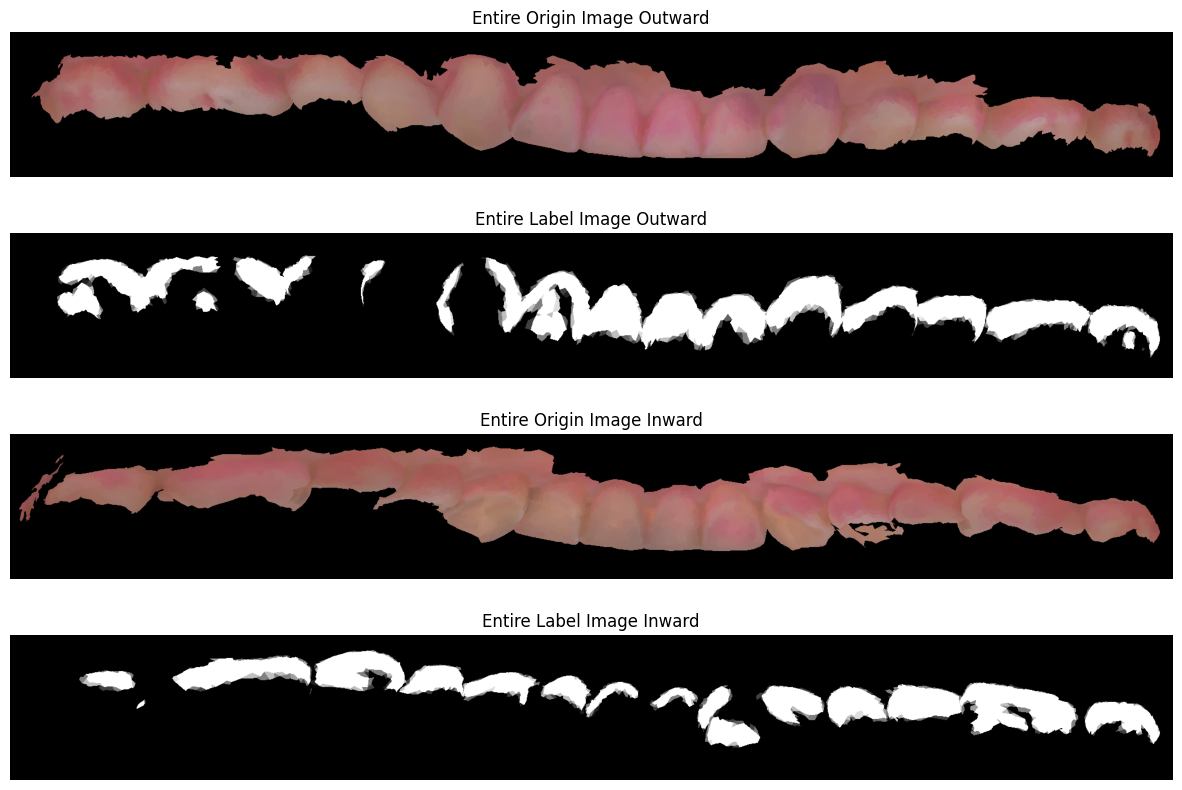

In [225]:
# Display the large image for visualization
fig, ax = plt.subplots(4,1, figsize=(15, 10))

ax[0].imshow(entire_origin_image_out)
ax[0].set_title("Entire Origin Image Outward")
ax[0].axis('off')


ax[1].imshow(entire_label_image_out)
ax[1].set_title("Entire Label Image Outward")
ax[1].axis('off')

ax[2].imshow(entire_origin_image_in)
ax[2].set_title("Entire Origin Image Inward")
ax[2].axis('off')

ax[3].imshow(entire_label_image_in)
ax[3].set_title("Entire Label Image Inward")
ax[3].axis('off')

# plt.savefig(os.path.join(save_dir, "jpg", f"{mesh_name}.jpg"))

plt.show()

In [226]:

# save_origin_path = os.path.join(save_dir, "origin", f'{mesh_name}.npy')
# save_label_path = os.path.join(save_dir, "label", f'{mesh_name}.npy')

# # Save the section images as a single npy file
# np.save(save_origin_path, origin_images)
# np.save(save_label_path, label_images_binary)


In [227]:
# tensor_origin = np.load(save_origin_path)
# tensor_label = np.load(save_label_path)
# origin_image_test = tensor_origin[4, :, :, :]
# label_image_test = tensor_label[4, :, :]

# fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# ax[0].imshow(origin_image_test)
# ax[0].axis("off")
# ax[1].imshow(label_image_test)
# ax[1].axis("off")
# plt.show()

In [228]:
# # convert rgb to bgr
# origin_image_test = cv2.cvtColor(origin_image_test, cv2.COLOR_RGB2BGR)
# label_image_test = cv2.cvtColor(label_image_test, cv2.COLOR_RGB2BGR)

# # save origin_image_test and label_image_test as jpg
# cv2.imwrite(os.path.join(save_dir, "jpg", f"{mesh_name}_origin_image_test.jpg"), origin_image_test)
# cv2.imwrite(os.path.join(save_dir, "jpg", f"{mesh_name}_label_image_test.jpg"), label_image_test)



Planar Projection of upper surface

In [338]:
mesh_up = upward_mesh
triangles_up = np.asarray(mesh_up.triangles)
label_mesh_up = copy.deepcopy(label_mesh)
label_mesh_up.triangles = o3d.utility.Vector3iVector(triangles_up)


# Extract the vertices, triangles, vertex colors and face colors
vertices_up = np.asarray(mesh_up.vertices)

vertex_colors_up = np.asarray(mesh_up.vertex_colors)
face_colors_up = get_face_colors(triangles_up, vertex_colors_up)
vertex_labels_up = np.asarray(label_mesh_up.vertex_colors)
face_labels_up = get_face_colors(triangles_up, vertex_labels_up)

# Flip face_labels colors (white (1,1,1) to black (0,0,0), black to white)
face_colors_up = (face_colors_up * 255).astype(np.uint8)
face_labels_up = ((1 - face_labels_up) * 255).astype(np.uint8)


# Projection
uv_up, vert_depth_up = vertices_up[:, [0, 2]], vertices_up[:, 1]





def normalize_uv_coord_up(uv_coords,
                          x_range=(-35, 35),
                          z_range=(0, 50)):
    uv_coords_norm = np.copy(uv_coords)
    x_min, x_max = x_range
    z_min, z_max = z_range
    uv_coords_norm[:, 0] = (uv_coords[:, 0] - x_min) / (x_max - x_min)
    uv_coords_norm[:, 1] = (uv_coords[:, 1] - z_min) / (z_max - z_min)
    return uv_coords_norm



# Normalize the uv coordinates into [0, 1]
uv_norm_up = normalize_uv_coord_up(uv_up)

In [339]:
print(np.min(uv_up[:,0]), np.max(uv_up[:,0]))
print(np.min(uv_up[:,1]), np.max(uv_up[:,1]))

-38.73618602011798 35.032498416464044
-0.38066689722832375 51.923968237360874


In [340]:
# count number of vertice colors != (0,0,0)
print(np.sum(face_labels_up != 0., axis=0))
print(face_labels_up[-1])

print(len(face_labels_up))
print(len(triangles_up))

[531 531 531]
[0 0 0]
16408
16408


In [341]:
px = 1024
# Convert uv cooridnates to pixel coordinates, scaling x,z to [0,1024) range
uv_pixel_up = np.copy(uv_norm_up)
uv_pixel_up[:, 0] = (uv_pixel_up[:, 0] * px-1).astype(np.int32)
uv_pixel_up[:, 1] = (uv_pixel_up[:, 1] * px-1).astype(np.int32)



# Initialize the large 2D image (1024x1024x3) for the entire dataset
origin_image_up = np.zeros((px, px, 3), dtype=np.uint8)
label_image_up = np.zeros((px, px, 3), dtype=np.uint8)


# Rasterize the triangles onto the large image
# Crop the large image into 8 sections, each with size 256x256x3
def rasterize(triangles, face_colors, uv_pixel, large_image):
    """ Return section_images as numpy arrays, with shape (1024, 1024, 3)"""
    print(np.sum(face_colors != 0., axis=0))
    print(len(face_colors))
    for i, triangle in enumerate(triangles):
        pts = uv_pixel[triangle].reshape((-1, 1, 2)).astype(np.int32)
        
        face_color = tuple(int(c) for c in face_colors[i])  # Convert to tuple for cv2.fillPoly
        cv2.fillPoly(large_image, [pts], face_color)
    return large_image



# Rasterize the triangles onto the large image
origin_image_up = rasterize(triangles_up, face_colors_up, uv_pixel_up, origin_image_up)
label_image_up = rasterize(triangles_up, face_labels_up, uv_pixel_up, label_image_up)
# label_images_binary_up = convert_to_binary(label_image_up)

print(np.max(face_labels_up))
print(np.max(label_image_up))

[16408 16408 16408]
16408
Triangle 0: Points [[[684 868]]

 [[681 871]]

 [[685 871]]], Color [150 118 114]
Triangle 1: Points [[[685 871]]

 [[688 867]]

 [[684 868]]], Color [152 117 112]
Triangle 2: Points [[[682 866]]

 [[681 871]]

 [[684 868]]], Color [150 117 109]
Triangle 3: Points [[[682 866]]

 [[677 869]]

 [[681 871]]], Color [150 117 109]
Triangle 4: Points [[[698 857]]

 [[694 863]]

 [[698 862]]], Color [152 119 108]
Triangle 5: Points [[[687 864]]

 [[684 868]]

 [[688 867]]], Color [152 116 109]
Triangle 6: Points [[[703 856]]

 [[698 862]]

 [[709 855]]], Color [157 121 107]
Triangle 7: Points [[[698 862]]

 [[703 856]]

 [[698 857]]], Color [156 120 108]
Triangle 8: Points [[[694 859]]

 [[688 867]]

 [[694 863]]], Color [152 117 108]
Triangle 9: Points [[[684 863]]

 [[684 868]]

 [[687 864]]], Color [152 116 109]
Triangle 10: Points [[[684 868]]

 [[684 863]]

 [[682 866]]], Color [152 117 109]
Triangle 11: Points [[[677 864]]

 [[677 869]]

 [[682 866]]], Color [1

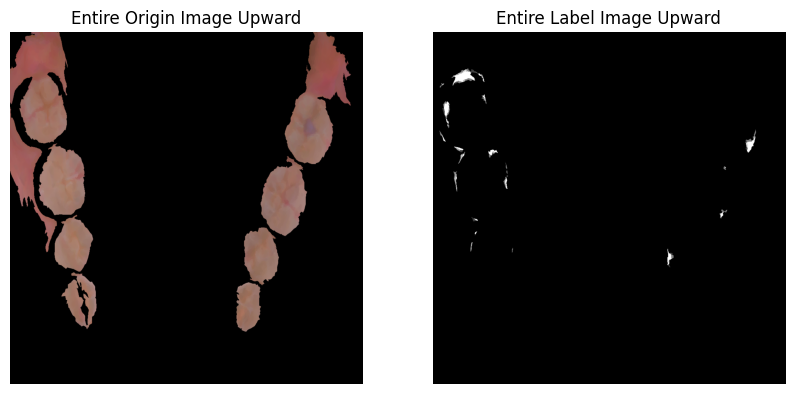

In [342]:
# Display the large image for visualization
fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].imshow(origin_image_up)
ax[0].set_title("Entire Origin Image Upward")
ax[0].axis('off')

ax[1].imshow(label_image_up)
ax[1].set_title("Entire Label Image Upward")
ax[1].axis('off')

# plt.savefig(os.path.join(save_dir, "jpg", f"{mesh_name}_upward.jpg"))

plt.show()

### Map back to 3D

In [337]:

# FIXME:!!!!!!
# In contrast, GT: vertex_labels_out, vertex_labels_in are not flipped, RGB (0-1)

# Assuming the predicted label images has been converted from binary masks to RGB images (0-255)
# intensity flipped (1 to 0, 0 to 1)
# white-grey: non-zero (>0) class 1; black: (0,0,0) class 0
predicted_label_images = label_images  # Directly load the GT label images as the predicted label images (ideal case test)

# Reshape the predicted label images into the original 8x1024x1024 format from the 16x256x256 format
print(predicted_label_images.shape)
predicted_label_images = predicted_label_images.reshape(2, 8, px_h, px_h, 3)
# Divide by 255 to convert back to [0, 1] range and flip the intensity (1 to 0, 0 to 1)
# black-grey: non-1s (<1) class1; white: (1,1,1) class 0 (same format as mesh GT labels)
predicted_label_images = 1 - predicted_label_images / 255


def determine_pred_labels_for_uv(uv_pixel_in, uv_pixel_out, predicted_label_images):
    """ Assign labels to points based on predicted label images """
    # Initialize arrays to store the labels of each point or triangle
    vertex_pred_labels_out = np.zeros((uv_pixel_out.shape[0], 3), dtype=np.int8)
    vertex_pred_labels_in = np.zeros((uv_pixel_in.shape[0], 3), dtype=np.int8)
    
    for i, (u, v) in enumerate(uv_pixel_out):
        section = int(u // px_h) # Determine the section of the point
        local_u = int(u % px_h) # Determine the local u coordinate within the section
        v = np.clip(int(v), 0, 255) # Ensure the v coordinate is within the pixel y range
        vertex_pred_labels_out[i] = predicted_label_images[0, section, v, local_u] # 0 for outward-facing

    for i, (u, v) in enumerate(uv_pixel_in):
        section = int(u // px_h) # Determine the section of the point
        local_u = int(u % px_h) # Determine the local u coordinate within the section
        v = np.clip(int(v), 0, 255) # Ensure the v coordinate is within the pixel y range
        vertex_pred_labels_in[i] = predicted_label_images[1, section, v, local_u] # 1 for inward-facing
    return vertex_pred_labels_out, vertex_pred_labels_in


# Determine the labels for the points in 'out' and 'in' UV coordinates
vertex_pred_labels_out, vertex_pred_labels_in = determine_pred_labels_for_uv(uv_pixel_in, uv_pixel_out, predicted_label_images)

# # For each triangle, determine the label by majority voting (or another method) based on its vertices' labels
# face_pred_labels_out = np.array([np.argmax(np.bincount(vertex_pred_labels_out[triangle])) for triangle in sorted_triangles_out])
# face_pred_labels_in = np.array([np.argmax(np.bincount(vertex_pred_labels_in[triangle])) for triangle in sorted_triangles_in])

# Now, triangle_labels_out and triangle_labels_in contain the labels for each triangle based on the predicted label images
# FIXME: Compare the predicted labels with the ground truth labels to evaluate the model
# FIXME: point_labels vs vertex_labels (GT); triangle_labels vs face_labels (GT) --> compute IoU, Dice, etc. metrics
print(np.unique(vertex_labels_out))
print(vertex_labels_out[0])
print(np.unique(vertex_pred_labels_out))
print(vertex_pred_labels_out[0])

# Compute the IoU and Dice scores for the vertices
def compute_metrics(gt_labels, pred_labels, binary=True):
    """ Compute the IoU and Dice scores for the outward-facing faces """
    if binary:
        gt_labels = gt_labels != np.array([0.,0.,0.]) # returns True if label <1 (class1), False if label is 1 (white class0)
        pred_labels = pred_labels != np.array([0,0,0])
    intersection = np.sum(np.logical_and(gt_labels, pred_labels))
    union = np.sum(np.logical_or(gt_labels, pred_labels))
    iou = intersection / union
    dice = 2 * intersection / (np.sum(gt_labels) + np.sum(pred_labels))
    return iou, dice

iou_out, dice_out = compute_metrics(vertex_labels_out, vertex_pred_labels_out)
iou_in, dice_in = compute_metrics(vertex_labels_in, vertex_pred_labels_in)

print(f"IoU (outward): {iou_out:.4f}, Dice (outward): {dice_out:.4f}")
print(f"IoU (inward): {iou_in:.4f}, Dice (inward): {dice_in:.4f}")

(16, 256, 256, 3)
[0.         0.03137255 0.0627451  0.1254902  0.18823529 0.25098039
 0.31372549 0.37647059 0.43921569 0.50196078 0.56078431 0.62352941
 0.68627451 0.74901961 0.81176471 0.8745098  0.9372549  1.        ]
[1. 1. 1.]
[0 1]
[0 0 0]
IoU (outward): 0.7561, Dice (outward): 0.8611
IoU (inward): 0.8000, Dice (inward): 0.8889


In [202]:
# visualize the predicted label images in mesh form
def visualize_pred_labels(GTlabel_mesh, vertex_pred_labels): # assume vertex_pred_labels is in RGB format (0-1) non-binary
    """ Visualize the predicted labels on the mesh """
    mesh_pred = copy.deepcopy(GTlabel_mesh)
    vertices = np.asarray(mesh_pred.vertices)
    triangles = np.asarray(mesh_pred.triangles)
    colors = np.asarray(mesh_pred.vertex_colors).astype(np.int8)



    for i in range(len(vertices)):
       if not np.array_equal(vertex_pred_labels[i], np.array([1, 1, 1])):  # Check if predicted label is not white
            if np.array_equal(colors[i], np.array([1, 1, 1])):  # False positive
                colors[i] = np.array([1, 0, 0]) # Red
            else: # True positive
                colors[i] = np.array([0, 1, 0]) # Green
        
    mesh_pred.vertex_colors = o3d.utility.Vector3dVector(colors)

    return mesh_pred

In [204]:
mesh_pred_out = visualize_pred_labels(label_mesh_out, vertex_pred_labels_out)
mesh_pred_in = visualize_pred_labels(label_mesh_in, vertex_pred_labels_in)

# set scene background to grey
# o3d.visualization.draw_geometries([mesh_pred_out, mesh_pred_in, coordinate_frame, grid])

# Visualize the meshes with a grey background
def custom_draw_geometry_with_background(geometry_list, window_name="Open3D"):
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name=window_name)
    for geometry in geometry_list:
        vis.add_geometry(geometry)
    opt = vis.get_render_option()
    opt.background_color = np.asarray([0.5, 0.5, 0.5])
    vis.run()
    vis.destroy_window()

custom_draw_geometry_with_background([mesh_pred_out, mesh_pred_in], window_name="Predicted Labels")
